This notebook performs some basic analysis on the dataset which drove the NN design.

# Retrieve dataset

Download the dataset in TFRecords file format. Alternatively, create your own train/test files exploiting the code convert_to_TFRecords.ipynb and place them in "hyperspectral-cnn-soil-estimation/dataset".

In [ ]:
%cd
%cd hyperspectral-cnn-soil-estimation/dataset

#Challenge train set: will be used for training and validation
!gdown https://drive.google.com/uc?id=1wD3vKqKEFh6OfrfLNtOENF-lbe4auQDb

#Challenge test set: no labels are provided, will be used for making inference
!gdown https://drive.google.com/uc?id=1XPaSRHsGHGkLieZnR6cU8-Bwg6_1kCTj

%cd

# Load dataset

Navigate to the working directory.

In [1]:
%cd
%cd hyperspectral-cnn-soil-estimation

/home/microsat
/home/microsat/hyperspectral-cnn-soil-estimation


Define dataset paths.

In [2]:
train_set_path = 'dataset/train_tfrecords0.record'
test_set_path = 'dataset/test_tfrecords0.record'

Import required libraries and load the dataset.

In [3]:
import os, logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
from dataset_processing import *
from dataset_analysis import *
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

train_data=load_tf_records(train_set_path)
test_data=load_tf_records(test_set_path)

Check the number of train and test images.

In [4]:
num_train_images = len(list(train_data))
print('train/val images: ', num_train_images)

num_test_images = len(list(test_data))
print('test images: ', num_test_images)

train/val images:  1732
test images:  1154


Decode TFRecord files.

In [5]:
train_data=train_data.map(decode_dataset_train_val)
test_data=test_data.map(decode_dataset_test)

# Analyze dataset

Calculate maximum and mimimum reflectance values both for train and test data.

In [6]:
max_value_train = max_reflectance_train(train_data)
min_value_train = min_reflectance_train(train_data)
print('Max reflectance in train:', max_value_train)
print('Min reflectance in train:', min_value_train)

max_value_test = max_reflectance_test(test_data)
min_value_test = min_reflectance_test(test_data)
print('Max reflectance in test:', max_value_test)
print('Min reflectance in test:', min_value_test)

max_reflectance = np.amax([max_value_test, max_value_train])
print('Overall max reflectance:', max_reflectance)

Max reflectance in train: 5419
Min reflectance in train: -3
Max reflectance in test: 6315
Min reflectance in test: -13
Overall max reflectance: 6315


Calculate maximum height and width on the whole dataset.

In [7]:
shape_data_train = np.array(list(train_data.map(lambda image, label, height, width: tf.shape(image)[0:2]).as_numpy_iterator()))
h_dims_train, w_dims_train = np.hsplit(shape_data_train, 2)

shape_data_test = np.array(list(test_data.map(lambda filename, image, height, width: tf.shape(image)[0:2]).as_numpy_iterator()))
h_dims_test, w_dims_test = np.hsplit(shape_data_test, 2)

max_height_train = np.amax(h_dims_train)
max_width_train = np.amax(w_dims_train)
print('Max height train:', max_height_train)
print('Max width train:', max_width_train)

max_height_test = np.amax(h_dims_test)
max_width_test = np.amax(w_dims_test)
print('Max height test:', max_height_test)
print('Max width test:', max_width_test)

max_height = np.amax([max_height_test, max_height_train])
max_width = np.amax([max_width_test, max_width_train])
print('Max height:', max_height)
print('Max width:', max_width)

Max height train: 268
Max width train: 284
Max height test: 229
Max width test: 273
Max height: 268
Max width: 284


Show image size distribution.

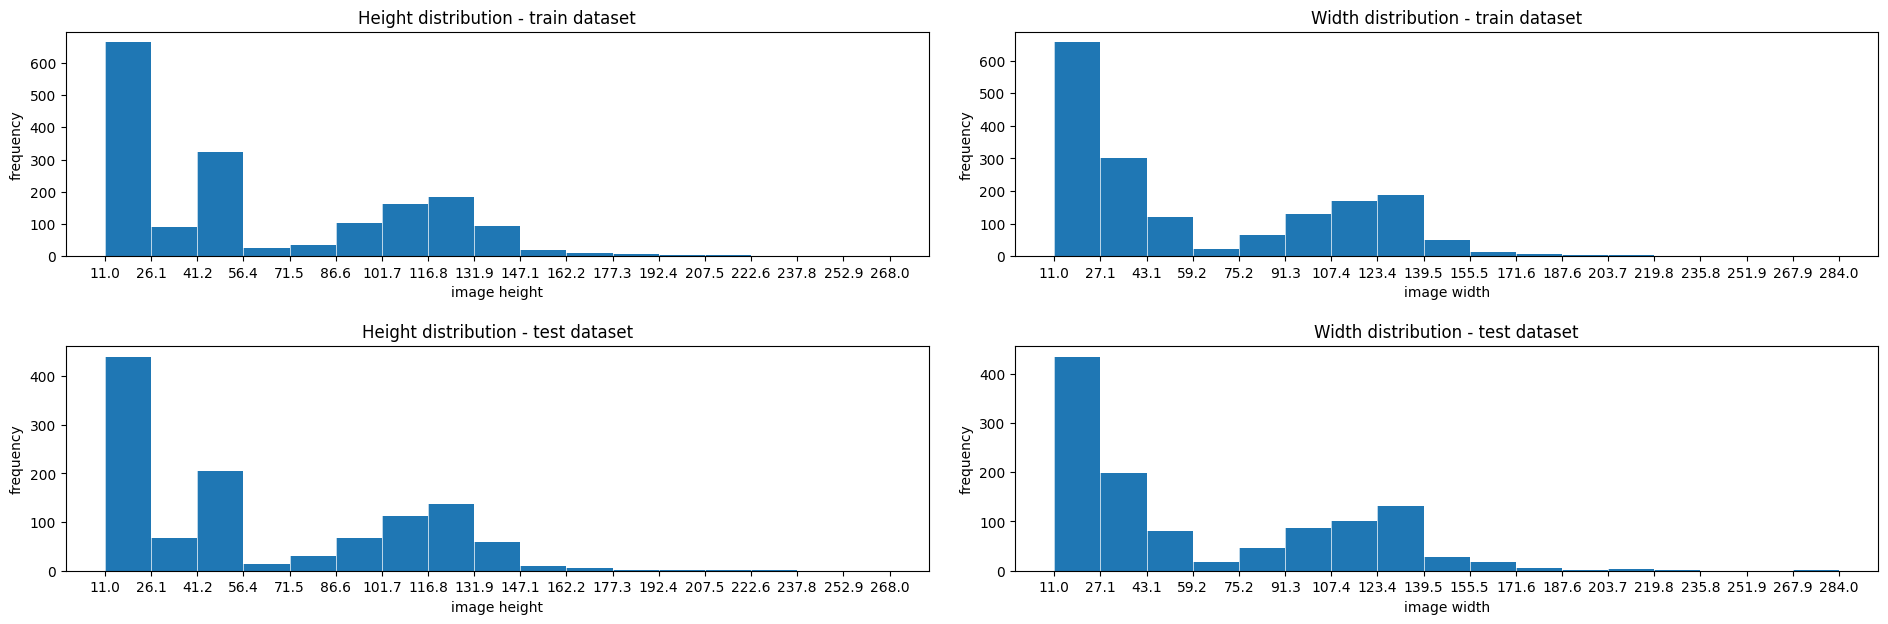

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(25,7))

plt.subplots_adjust(wspace=0.1, hspace=0.4, right=0.85)

n_h, bins_h, patches_h = axs[0,0].hist(h_dims_train, bins='auto')
axs[0,0].set_title('Height distribution - train dataset')
axs[0,0].set_xlabel('image height')
axs[0,0].set_ylabel('frequency')
axs[0,0].set_xticks(bins_h)
axs[0,0].grid(color='white', lw = 0.5, axis='x')

n_w, bins_w, patches_w = axs[0,1].hist(w_dims_train, bins='auto')
axs[0,1].set_title('Width distribution - train dataset')
axs[0,1].set_xlabel('image width')
axs[0,1].set_ylabel('frequency')
axs[0,1].set_xticks(bins_w)
axs[0,1].grid(color='white', lw = 0.5, axis='x')

n_h, bins_h, patches_h = axs[1,0].hist(h_dims_test, bins=bins_h)
axs[1,0].set_title('Height distribution - test dataset')
axs[1,0].set_xlabel('image height')
axs[1,0].set_ylabel('frequency')
axs[1,0].set_xticks(bins_h)
axs[1,0].grid(color='white', lw = 0.5, axis='x')

n_w, bins_w, patches_w = axs[1,1].hist(w_dims_test, bins=bins_w)
axs[1,1].set_title('Width distribution - test dataset')
axs[1,1].set_xlabel('image width')
axs[1,1].set_ylabel('frequency')
axs[1,1].set_xticks(bins_w)
axs[1,1].grid(color='white', lw = 0.5, axis='x')

plt.show()

Calculate average, median and standard deviation for ground truth values from train set labels.

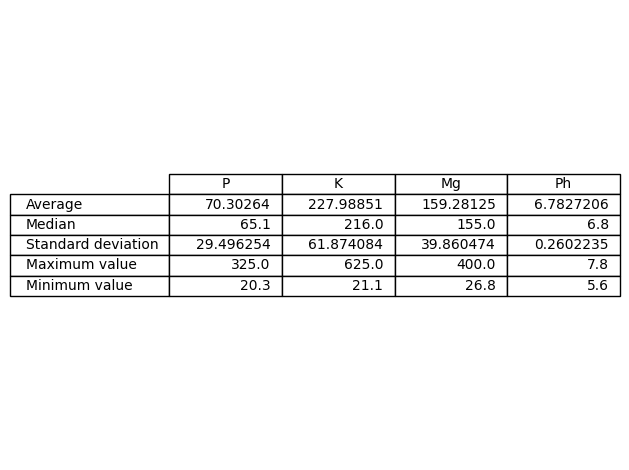

In [9]:
gt_data = np.array(list((train_data.map(lambda image, label, height, width: label)).as_numpy_iterator()))

gt_avg = np.mean(gt_data, axis=0)
gt_median = np.median(gt_data, axis=0)
gt_std = np.std(gt_data, axis=0)
gt_max = np.amax(gt_data, axis=0)
gt_min = np.amin(gt_data, axis=0)
gt_stats = np.append([gt_avg], [gt_median, gt_std, gt_max,gt_min], axis=0)

fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

df=pd.DataFrame(gt_stats, columns=['P', 'K', 'Mg', 'Ph'],)

ax.table(cellText=df.values, colLabels=df.columns, rowLabels=['Average', 'Median', 'Standard deviation', 'Maximum value','Minimum value'], loc='center')

fig.tight_layout()

plt.show()

Find baseline mse in order to later define evaluation metrics.

In [10]:
mse_baseline = np.mean((gt_data-gt_avg)**2, axis=0)
print(mse_baseline)

[8.7002899e+02 3.8284023e+03 1.5888574e+03 6.7716271e-02]


Print some entries from train set.

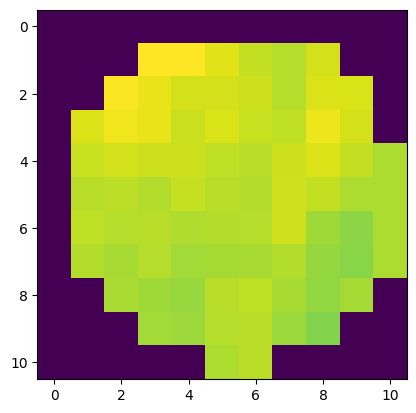

[ 45.1 188.  179.    7.2]


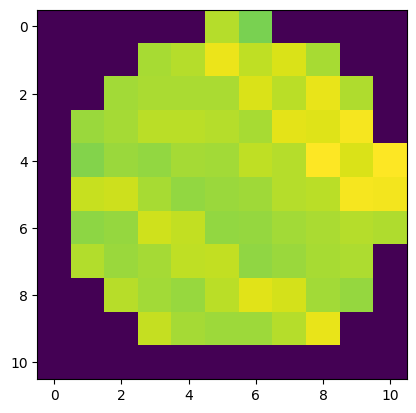

[ 44.8 205.  188.    7. ]


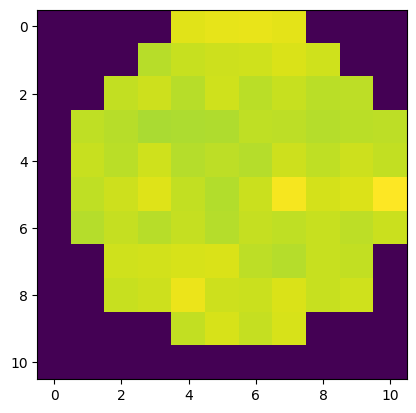

[ 44.4 207.  145.    6.8]


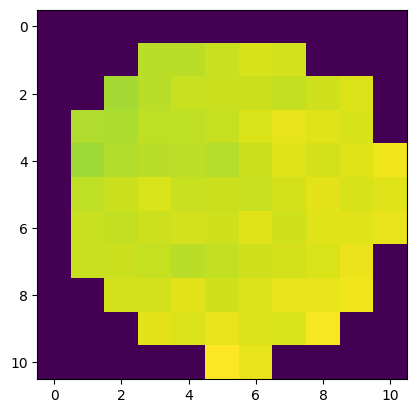

[ 46.5 204.  143.    6.8]


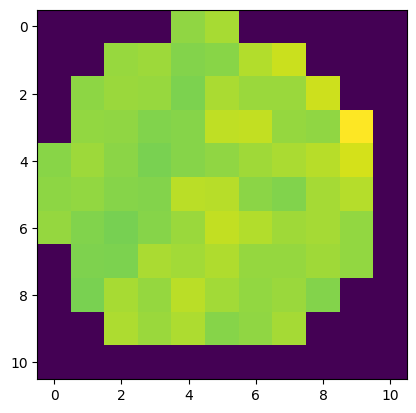

[ 52.  212.  167.    6.7]


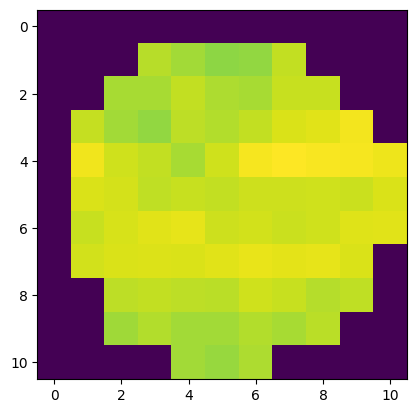

[ 50.1 206.  184.    6.8]


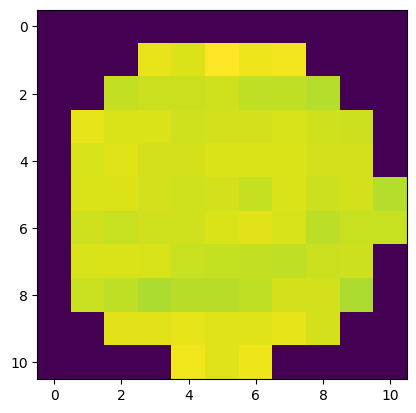

[ 66.5 194.  150.    7. ]


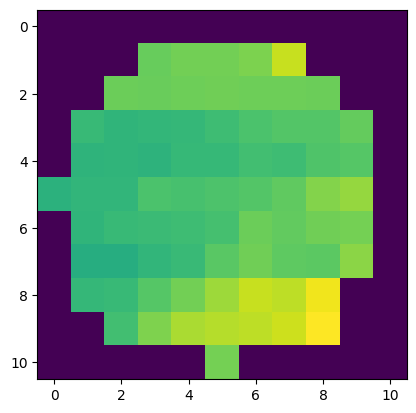

[ 67.4 199.  149.    7.1]


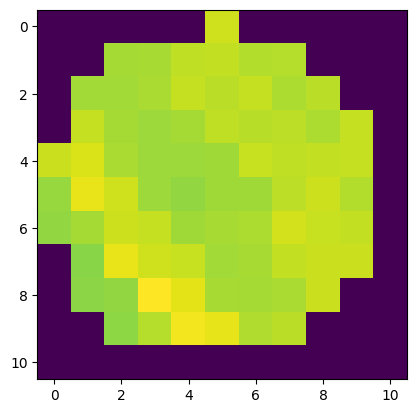

[ 76.2 202.  151.    7.1]


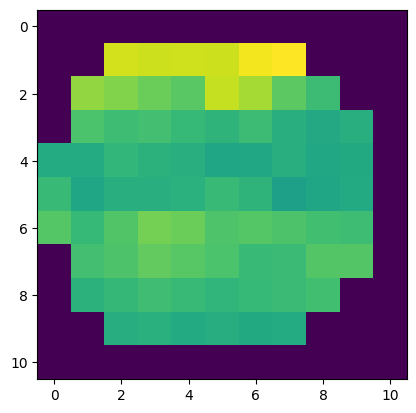

[ 74.3 219.  164.    7.2]


In [11]:
for image, label, height, width in train_data.take(10):
  plt.imshow(image[:,:,75].numpy())
  plt.show()
  print(label.numpy())


Print some entries from test set.

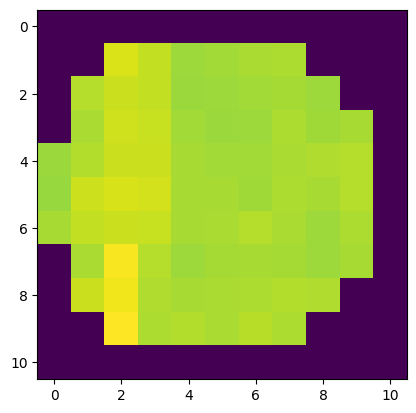

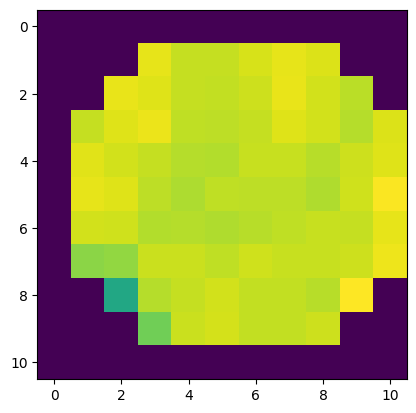

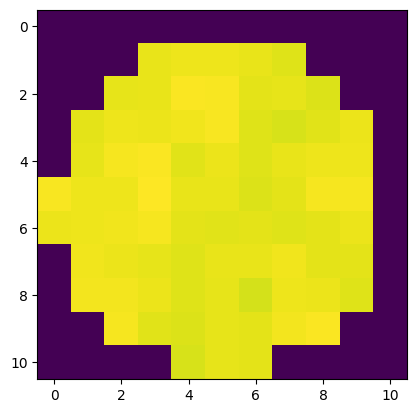

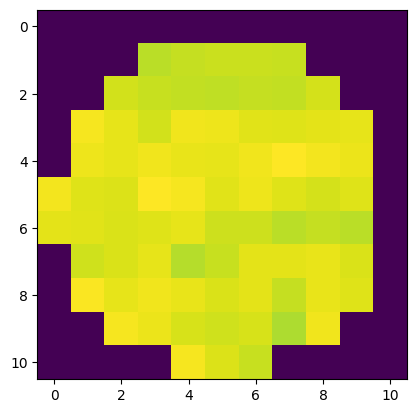

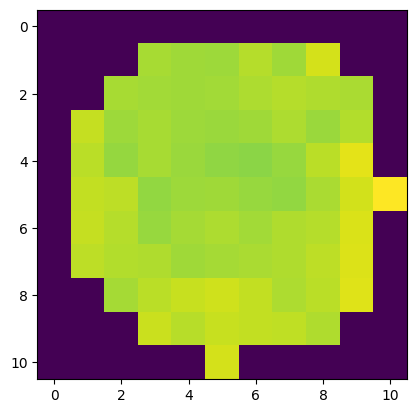

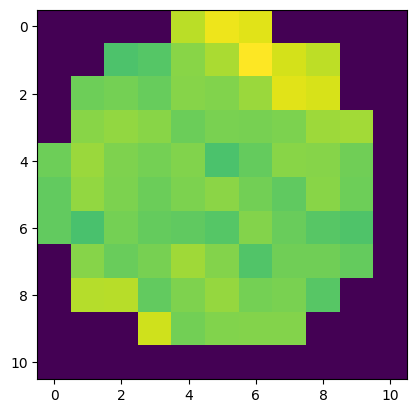

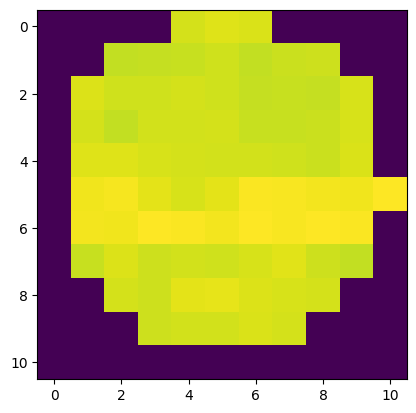

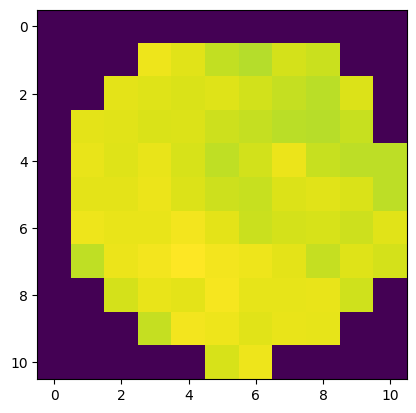

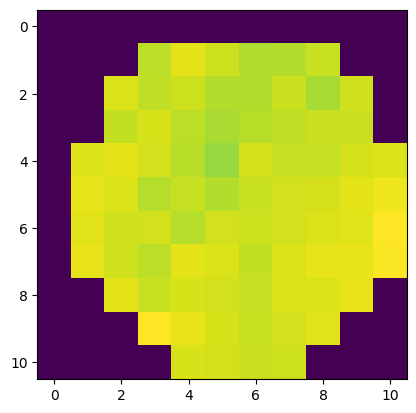

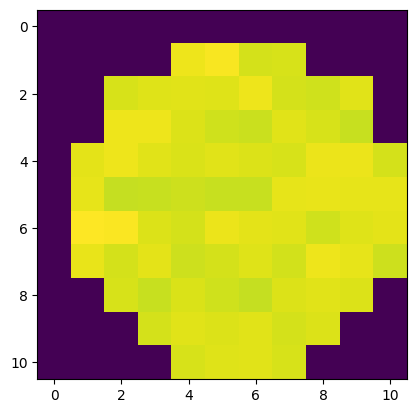

In [12]:
i=1
for filename, image, height, width in test_data.take(10):
    plt.imshow(image[:,:,75].numpy())
    plt.show()